In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat, u_darrays
from scipy.stats import gaussian_kde, binned_statistic
import pickle as pkl
from utils import u_plot as uplot, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))

In [4]:
print(OBS.keys())

dict_keys(['tmin', 'p', 'month', 'pmax', 'u925', 'tmean', 'v650', 'w925', 'div925', 'div650', 't', 'q650', 'u650', 'area', 'w650', 'hour', 'pgt30', 'v925', 'year', 't650', 'shear', 'rh925', 'clon', 'pgt01isvalid', 'pv925', 't925', 'rh650', 'q925', 'pmean', 'pv650', 'clat', 'lon', 'lat'])


In [5]:
dic = OBS

pp = np.array(dic['pmax'])
sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['u650'])
umax = np.array(dic['u925'])
qq = np.array(dic['q925']) 
rh = np.array(dic['rh925']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

obs_pcp = {
    'prcp' : pp,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'rhtot' : rh,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*7.7**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
obs = pd.DataFrame(obs_pcp)

In [6]:
def get_ERA(era, indic, clim=False):

    dic = {}
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    dic['rh925'] = []
    
    for id, date in enumerate(indic.date):
        
        if clim == True:
            getera =np.where((era['time.month']==indic.month[id]) & (era['time.year']==indic.year[id]))

        else:
            getera =np.where((era['time.day']==(indic['date'])[id].day) & (era['time.month']==indic.month[id]) & (era['time.year']==indic.year[id]))

        try:
            era_day = era.isel(time=int(getera[0]))
        except TypeError:
            print('Era missing')
            for k in dic.keys():
                dic[k].append(np.nan)

            continue

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['u925'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['u650'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=650, method='nearest').values))
        dic['q925'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['q700'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=700, method='nearest').values))
        dic['rh925'].append(float(era_day['r'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))

    return dic

In [7]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))
pdf = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12))
pdf = pdf.dropna()

ttg = np.array(pdf.tmin, dtype=float)
ttm = np.array(pdf.tmean, dtype=float)
month = pdf.month.values
area = pdf.area.values
area70 = np.array(pdf['70area'], dtype=int)
lat = pdf.clat.values
lon = pdf.clon.values

In [8]:
era = xr.open_dataset(cnst.ERA_DAILY_PL12UTC)
era = u_darrays.flip_lat(era)

In [9]:
# era_out = get_ERA(era, pdf)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA_qhistogram.p', 'wb'))

In [52]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC_front.p', 'rb'))
era_clim = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC_front_CLIM.p', 'rb'))

In [53]:
era_out.keys()

dict_keys(['q_col', 'q_col_s', 'CAPE', 'u925', 'tmean', 'q925_s', 'tmin', 'u925_s', 'dates', 'level', 'area', 'u650', 'tcwv_s', 'u650_s', 'tcwv', 'u_col', 'q925', 'v_col_s', 'CAPE_s', 'v_col', 'q700_s', 'area70', 't10', 'u_col_s', 'r_col_s', 'r_col', 'lon', 'q700', 'lat'])

In [54]:
def get_col(var):
    vdic = {}
    vdic['low'] = []
    vdic['high'] = []
    vdic['mean'] = []
    for v in var:
        
        vdic['low'].append(v.flatten()[16])
        vdic['high'].append(v.flatten()[9])
        vdic['mean'].append(np.array(v).flatten().mean())        
    return vdic
    
udic = get_col(era_out['u_col'])
vdic = get_col(era_out['v_col'])
ucdic = get_col(era_clim['u_col'])
vcdic = get_col(era_clim['v_col'])

ushear = (np.array(udic['high'])-np.array(udic['low'])) - (np.array(ucdic['high'])-np.array(ucdic['low']))
vshear = (np.array(vdic['high'])-np.array(vdic['low'])) - (np.array(vcdic['high'])-np.array(vcdic['low']))

shearss = u_met.u_v_to_ws_wd(ushear, vshear)

In [55]:
e_u650 = np.array(era_out['u650'])  - np.array(era_clim['u650'])
e_u925 = np.array(era_out['u925'])  - np.array(era_clim['u925'])
e_q925 = np.array(era_out['q925']) - np.array(era_clim['q925'])
e_q700 = np.array(era_out['q700']) - np.array(era_clim['q700'])

In [56]:
era_out['month'] = []
for d in era_out['dates']:
    era_out['month'].append(d.month)

In [57]:
len(era_out['month'])

18878

In [58]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : shearss[0],
    'month' : era_out['month'],
    'area' : np.array(era_out['area'])*7.7**2,
    'tmin' : era_out['tmin'],
    'tmean' : era_out['tmean'],
    'lat' : era_out['lat'],
    'lon' : era_out['lon'],
} 
ds = pd.DataFrame(dic)

In [59]:
dic['area'].min()

4921.070000000001

In [60]:
ds = ds.dropna()

In [61]:
pos1 = (ds.month==3)  & (ds.u650<0) & (ds.area>=5000)
pos2 = (ds.month==10)  & (ds.u650<0) & (ds.area>=5000)

opos1 = (obs.month==3)  & (obs.u650<0) & (obs.area>=1000)
opos2 = (obs.month==10)  & (obs.u650<0) & (obs.area>=1000)

In [62]:
oposi = (obs.u650<0) & (obs.area>=5000) & (obs.prcp>=1) & ((obs.month>=9) | (obs.month<=5))

In [63]:
ds_march = ds[pos1]
ds_oct = ds[pos2]
obs_march = obs[opos1]
obs_oct = obs[opos2]

In [64]:
obsp = obs[oposi]

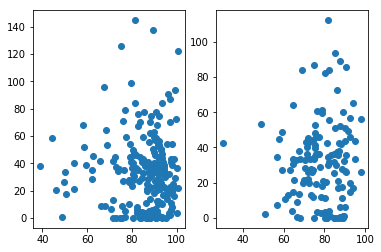

In [65]:
f = plt.figure()
ax = f.add_subplot(121)
plt.scatter(obs_oct.rhtot, obs_oct.prcp)
#plt.xlim(0,150)

ax = f.add_subplot(122)
plt.scatter(obs_march.rhtot, obs_march.prcp)
#plt.xlim(0,150)
#ax.set_ylim(0,130)

(array([ 9.,  5., 10., 12.,  9., 19.,  7., 10.,  5.,  6.,  3.,  3.,  0.,
         1.,  0.,  3.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([ 10.        ,  14.66666667,  19.33333333,  24.        ,
         28.66666667,  33.33333333,  38.        ,  42.66666667,
         47.33333333,  52.        ,  56.66666667,  61.33333333,
         66.        ,  70.66666667,  75.33333333,  80.        ,
         84.66666667,  89.33333333,  94.        ,  98.66666667,
        103.33333333, 108.        , 112.66666667, 117.33333333,
        122.        , 126.66666667, 131.33333333, 136.        ,
        140.66666667, 145.33333333, 150.        ]),
 <a list of 30 Patch objects>)

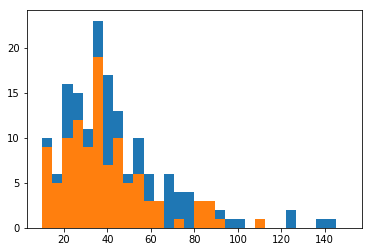

In [66]:
plt.hist(obs_oct.prcp, bins=30, range=(10,150))
plt.hist(obs_march.prcp, bins=30, range=(10,150))

In [67]:
print(np.percentile(obs_march.prcp,90))
print(np.percentile(obs_oct.prcp,90))

59.906640237483174
68.74397024805508


In [68]:
#March oct test
inputs = ds
pos_march = (inputs.month==3)  & (inputs.u650<0) & (inputs.area>=5000) #& (ds.q925>=12.5)
pos_oct = (inputs.month==10)  & (inputs.u650<0) & (inputs.area>=5000)
dss_march = inputs[pos_march]
dss_oct = inputs[pos_oct]

(array([  3.,   9.,  52., 213., 516., 499., 199.,  54.,   8.,   2.]),
 array([-2.81112175, -2.2145153 , -1.61790885, -1.0213024 , -0.42469595,
         0.17191051,  0.76851696,  1.36512341,  1.96172986,  2.55833631,
         3.15494277]),
 <a list of 10 Patch objects>)

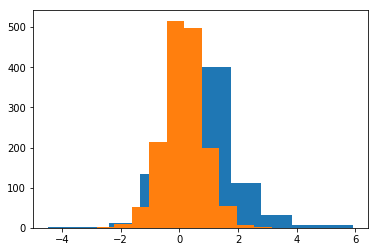

In [69]:
plt.hist(dss_march.q925)
plt.hist(dss_oct.q925)

In [70]:
dss_oct.shear

854      6.685332
855      5.205241
856      5.462972
857      4.019753
864      9.468341
867      3.229138
868      2.376202
869      2.145891
870      3.975778
871      5.541834
874      4.040791
878      1.853748
880      3.754888
881      4.849446
882      1.832489
901      4.435464
902      6.265232
906      4.105950
907      2.209949
910      4.013220
912      4.899977
913      5.228184
914      5.863323
916      8.559269
917      4.372503
919      4.424703
922      6.492866
923      3.708715
924      5.889800
927      6.879925
           ...   
18672    2.586651
18673    4.909940
18675    5.854661
18676    4.814132
18677    5.289323
18678    7.997410
18679    6.589296
18680    5.716139
18681    4.163824
18682    5.349176
18683    3.383643
18684    4.089108
18685    7.636221
18686    5.508180
18687    3.962391
18688    6.244519
18689    4.270598
18690    7.786901
18691    4.340700
18692    3.377458
18693    2.163176
18694    5.356584
18695    8.420298
18696    2.351388
18697    5

BinnedStatisticResult(statistic=array([  0.,   1.,   5.,   9.,  50., 179., 372., 474., 307., 122.,  28.,
         6.,   1.,   1.,   0.,   0.,   0.]), bin_edges=array([-3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,
        2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]), binnumber=array([ 6,  5,  5, ...,  8, 10,  8]))
BinnedStatisticResult(statistic=array([  0.,   1.,   1.,   9.,  14.,  80., 147., 219., 252., 188., 108.,
        58.,  31.,  14.,   9.,   4.,   2.]), bin_edges=array([-3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,
        2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]), binnumber=array([ 7,  6,  9, ...,  7, 12,  8]))


/home/ck/miniconda3/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Text(0, 0.5, 'Storm average Tmin')

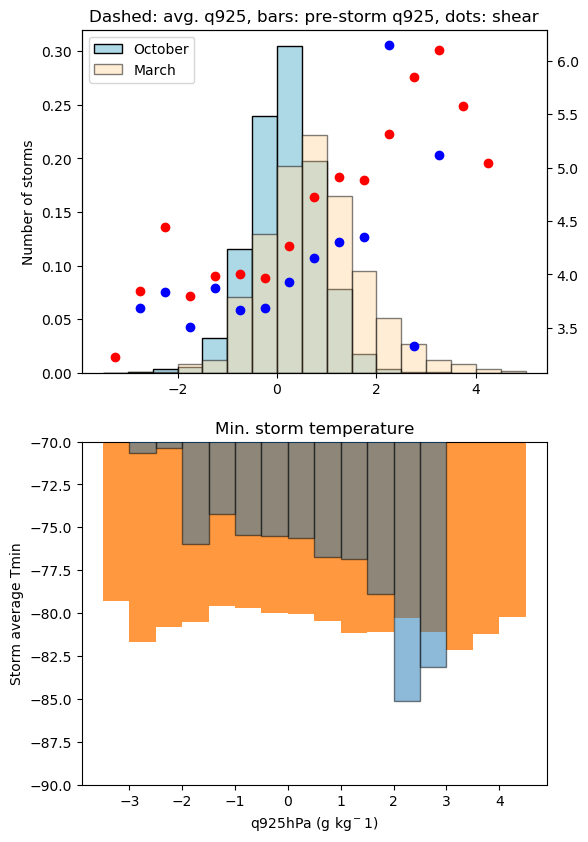

In [71]:
f = plt.figure(figsize=(6,10), dpi=100)
ax = f.add_subplot(211)

Ho = binned_statistic(dss_oct.q925, dss_oct.q925,bins=np.arange(-3.5,5.5,0.5),statistic='count')#plt.hist(dss_oct.q925, label='October', bins=12, range=(-4,5))
#std = binned_statistic(dss_oct.q925, dss_oct.q925, bins=12, statistic='std')


bins = Ho[1]
binmid = bins[1::]-((bins[1::]-bins[0:-1])/2)
#Ho = plt.hist(dss_oct.q925, label='October', alpha=0.8, bins=12, range=(-4,5))
plt.bar(binmid, Ho[0]/np.sum(Ho[0]),  color='lightblue', ecolor='black', edgecolor='k', width=0.5, label='October')
#ipdb.set_trace()

print(Ho)
#plt.vlines(15.048924, 0, 1900, 'b', linestyle='dashed')
shears_oct = []
tmin_oct = []

for ids, qs in enumerate(bins[0:-2]):
    pos = (dss_oct.q925>=qs) & (dss_oct.q925<bins[ids+1])
    pick = dss_oct.where(pos)
   
    shears_oct.append(np.mean(pick.shear))
    tmin_oct.append(np.mean(pick.tmin))


Hm = binned_statistic(dss_march.q925, dss_march.q925, statistic='count', bins=np.arange(-3.5,5.5,0.5))#plt.hist(dss_oct.q925, label='October', bins=12, range=(-4,5))
#std = binned_statistic(dss_march.q925, dss_march.q925, bins=12, statistic='std')


print(Hm)
#plt.vlines(15.146461,0, 1900,'r', linestyle='dashed')
bins = Hm[1]
binmid = bins[1::]-((bins[1::]-bins[0:-1])/2)
plt.bar(binmid, Hm[0]/np.sum(Hm[0]),  color='navajowhite', ecolor='black', edgecolor='k', width=0.5, alpha=0.5, label='March')

shears_march = []
tmin_march = []
for ids, qs in enumerate(bins[0:-2]):
    pos = (dss_march.q925>=qs) & (dss_march.q925<bins[ids+2])
    pick = dss_march.where(pos)
    shears_march.append(np.mean(pick.shear))
    tmin_march.append(np.mean(pick.tmin))
    

ax1 = ax.twinx()

ax1.plot(binmid[0:-1],shears_oct, 'bo') 
ax1.plot(binmid[0:-1],shears_march, 'ro')


ax.set_ylabel('Number of storms')
plt.title('Dashed: avg. q925, bars: pre-storm q925, dots: shear')
ax.legend(loc='upper left')


ax = f.add_subplot(212)
plt.title('Min. storm temperature')
plt.bar(binmid[0:-1],tmin_oct, align='center', zorder=9, edgecolor='k', alpha=0.5, width=0.5)
plt.bar(binmid[0:-1],tmin_march, alpha=0.8, align='center', width=0.5)
ax.set_xlabel('q925hPa (g kg$^-1$)')
plt.ylim(-90,-70)
plt.ylabel('Storm average Tmin')

#plt.savefig(cnst.network_data + 'figs/barplot_storm_avgQ.jpg')

In [ ]:
f = plt.figure(figsize=(6,10), dpi=100)
ax = f.add_subplot(211)

Ho = plt.hist(dss_oct.q925, label='October', bins=10, range=(40,100))
bins = Ho[1]
binmid = bins[1::]-((bins[1::]-bins[0:-1])/2)
print(Ho)
#plt.vlines(15.048924, 0, 1900, 'b', linestyle='dashed')
shears_oct = []
tmin_oct = []
for ids, qs in enumerate(bins[0:-1]):
    pos = (dss_oct.q925>=qs) & (dss_oct.q925<bins[ids+1])
    pick = dss_oct.where(pos)
    shears_oct.append(np.mean(pick.u650))
    tmin_oct.append(np.mean(pick.tmin))
print(shears_oct)
  
Hm = plt.hist(dss_march.q925, label='March', alpha=0.8, bins=10, range=(40,100))
print(Hm)
#plt.vlines(15.146461,0, 1900,'r', linestyle='dashed')
bins = Hm[1]
binmid = bins[1::]-((bins[1::]-bins[0:-1])/2)
shears_march = []
tmin_march = []
for ids, qs in enumerate(bins[0:-1]):
    pos = (dss_march.q925>=qs) & (dss_march.q925<bins[ids+1])
    pick = dss_march.where(pos)
    
    shears_march.append(np.mean(pick.u650))
    tmin_march.append(np.mean(pick.tmin))

ax1 = ax.twinx()
ax1.plot(binmid,shears_oct, 'bo') 
ax1.plot(binmid,shears_march, 'ro')


plt.ylabel('Number of storms')
plt.title('Dashed: avg. q925, bars: pre-storm q925, dots: shear')
ax.legend(loc='upper left')


ax = f.add_subplot(212)
plt.title('Min. storm temperature')
plt.bar(binmid,tmin_oct, align='center', zorder=9, edgecolor='k', alpha=0.5)
plt.bar(binmid,tmin_march, alpha=0.8, align='center')
ax.set_xlabel('q925hPa (g kg$^-1$)')
plt.ylim(-83,-60)
plt.ylabel('Storm average Tmin')


In [ ]:
plt.hist(dss_oct.qtot, label='October', bins=10)
#plt.vlines(15.048924, 0, 3000, 'b', linestyle='dashed')

plt.hist(dss_march.qtot, label='March', alpha=0.8, bins=10)
#plt.vlines(15.146461,0, 3000,'r', linestyle='dashed')
plt.xlabel('q925hPa (g kg$^-1$)')
plt.ylabel('Number of storms')
plt.title('Dashed lines: average q925, bars: pre-storm q925')
plt.legend()

In [ ]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

fig = plt.figure(figsize=(15, 5), dpi=100)
cc=11


data1, r1 = density_plot(dss_march.q925, dss_march.u925)

ax1 = fig.add_subplot(121)
mappable = ax1.scatter(dss_march.q925, dss_march.u925, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
#plt.xlim(12,19)
ax1.set_ylabel('Shear')
ax1.set_xlabel('q925hPa')
ax1.set_title('P-corr. q/shear'+str(np.round(r1[0], decimals=2)), fontsize=cc)
ax1.tick_params(direction='in')
cbar = fig.colorbar(mappable)
cbar.set_label('Density')

data1, r1 = density_plot(dss_oct.q925, dss_oct.u925)

ax1 = fig.add_subplot(122)
mappable = ax1.scatter(dss_oct.q925, dss_oct.u925, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
#plt.xlim(12,19)
ax1.set_ylabel('Shear')
ax1.set_xlabel('q925hPa')
ax1.set_title('P-corr. q/shear'+str(np.round(r1[0], decimals=2)), fontsize=cc)
ax1.tick_params(direction='in')
cbar = fig.colorbar(mappable)
cbar.set_label('Density')


In [ ]:
plt.figure()
plt.scatter(dss_oct.q925,dss_oct.shear)
plt.xlim(12,19)
plt.figure()
plt.xlim(12,19)
plt.scatter(dss_march.q925,dss_march.shear, alpha=0.5)

In [ ]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [ ]:
print('Mean storm q, oct', np.mean(ds_oct.q925))
print('Mean storm q, march', np.mean(ds_march.q925))

In [ ]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)
dsperc_oct, dsp_oct, dsarea_oct, dsval_oct = create_2dhist(ds_oct, shearb_oct, qbinsb_oct)

In [ ]:
cp4perc_mar, cp4pr_mar, cp4area_mar, cp4val_mar = create_2dhist(cp4_march, shearc_march, qbinsc_march)
cp4perc_oct, cp4pr_oct, cp4area_oct, cp4val_oct = create_2dhist(cp4_oct, shearc_oct, qbinsc_oct)

In [ ]:
cp25perc_mar, pc25pr_mar, cp25area_mar, cp25val_mar = create_2dhist(cp25_march, shear25_march, qbinsc25_march)
cp25perc_oct, pc25pr_oct, cp25area_oct, cp25val_oct = create_2dhist(cp25_oct, shear25_oct, qbinsc25_oct)

In [ ]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist_rh(obsp, shear_obsp, qbinso)
cp4perc, pc4, cp4area, cp4val = create_2dhist(cp4p, shear_cp4p, qbinsc)
cp25perc, pc25, cp25area, cp25val = create_2dhist(cp25p, shear_cp25p, qbinsc25)

In [ ]:
pcobs.shape

In [ ]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

In [ ]:
print(ds_oct.shear.mean())
print(ds_oct.q925.mean())